# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [61]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [62]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned/'
selections = [
              'emu', 
              'ee', 'mumu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'lepton2_pt', #'dilepton1_pt_asym', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jet'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jet']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 'L', 'sigma_tt', 'sigma_z', 'sigma_w', 'k_fake', 'eff_e', 'eff_mu', 'eff_tau']

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[0, 1])

In [63]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    for b in fit_data._bins:
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates['signal'][b]
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[selection][b] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection != 'mu4j':
                continue

            bg_template = templates[bg][b][0]
            toy_data[selection][b] += bg_template

        # mixture

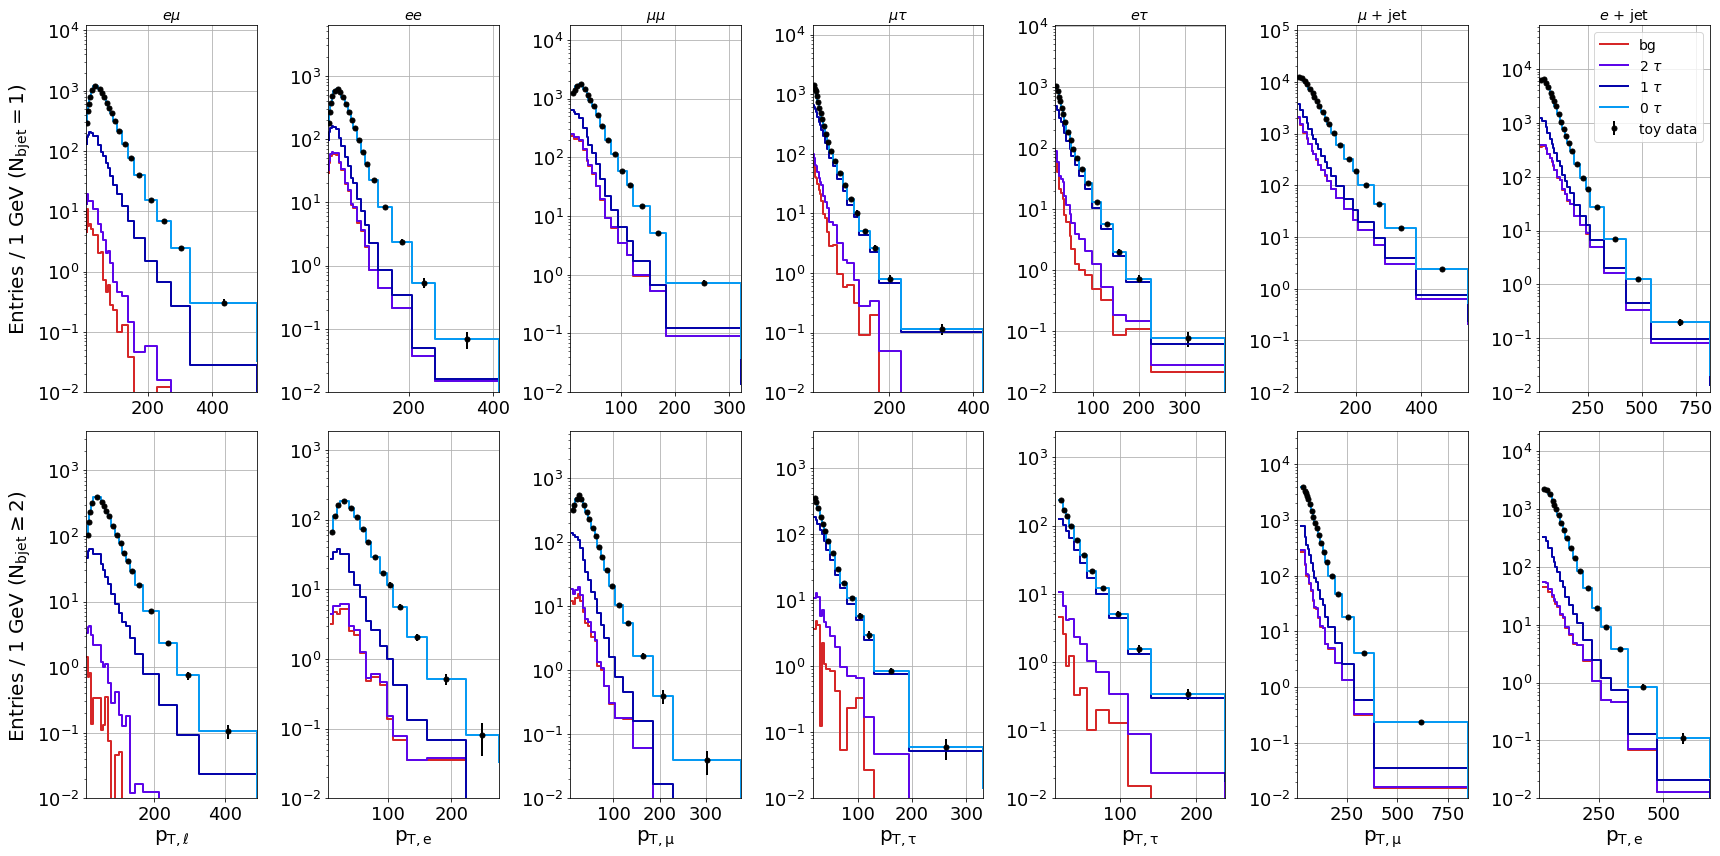

In [88]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for b in fit_data._bins:
        bins = s_data['bins'][b]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[b][i]
        data = toy_data[selection][b]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data['signal'][b]
        bg = s_data['wjets'][b][0] + s_data['zjets'][b][0]
        if selection == 'mu4j':
            bg += s_data['fakes'][b][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if b == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif b == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [65]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 5*[1., ] + 3*[1., ]# niceify this: there is an additional paramter initialized to 1. for each nuisance parameter
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [66]:
pd.set_option('precision', 3)
#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,0.729
B_mu,0.653
B_tau,1.608
B_h,0.277
L,1.803
sigma_tt,1.877
sigma_z,3.592
sigma_w,3.551
k_fake,3.529
eff_e,0.739


In [67]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau
B_e,1.000,-0.042,-0.082,-0.328,0.037,-0.026,0.055,0.058,0.169,-0.820,0.034,0.059
B_mu,-0.042,1.000,-0.146,-0.223,0.057,-0.041,0.156,0.017,0.144,0.056,-0.844,0.103
B_tau,-0.082,-0.146,1.000,-0.837,0.031,0.139,-0.276,0.230,-0.371,-0.322,-0.222,-0.895
B_h,-0.328,-0.223,-0.837,1.000,-0.066,-0.103,0.174,-0.244,0.218,0.623,0.510,0.767
L,0.037,0.057,0.031,-0.066,1.000,-0.960,-0.297,-0.326,-0.005,-0.063,-0.081,-0.026
sigma_tt,-0.026,-0.041,0.139,-0.103,-0.960,1.000,0.290,0.242,-0.125,-0.096,-0.071,-0.152
sigma_z,0.055,0.156,-0.276,0.174,-0.297,0.290,1.000,-0.032,0.196,-0.066,-0.193,0.222
sigma_w,0.058,0.017,0.230,-0.244,-0.326,0.242,-0.032,1.000,-0.100,-0.002,0.061,-0.153
k_fake,0.169,0.144,-0.371,0.218,-0.005,-0.125,0.196,-0.100,1.000,0.150,0.032,0.397
eff_e,-0.820,0.056,-0.322,0.623,-0.063,-0.096,-0.066,-0.002,0.150,1.000,0.229,0.339


In [68]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [69]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau
stat only,0.139,0.111,0.632,0.097,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
L,0.728,0.652,1.607,0.277,0.000,0.523,3.430,3.357,3.529,0.738,0.672,1.023
sigma_tt,0.729,0.652,1.593,0.276,0.503,0.000,3.438,3.445,3.501,0.736,0.672,1.012
sigma_z,0.728,0.645,1.546,0.273,1.722,1.796,0.000,3.549,3.460,0.737,0.661,0.998
sigma_w,0.728,0.653,1.565,0.269,1.704,1.821,3.590,0.000,3.511,0.739,0.673,1.012
k_fake,0.718,0.646,1.494,0.270,1.803,1.862,3.522,3.533,0.000,0.731,0.674,0.939
eff_e,0.417,0.652,1.522,0.217,1.799,1.868,3.584,3.551,3.489,0.000,0.656,0.963
eff_mu,0.728,0.350,1.568,0.238,1.797,1.872,3.524,3.544,3.527,0.719,0.000,0.990
eff_tau,0.728,0.649,0.716,0.178,1.802,1.855,3.502,3.509,3.239,0.695,0.652,0.000
full,0.729,0.653,1.608,0.277,1.803,1.877,3.592,3.551,3.529,0.739,0.674,1.024


### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [71]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)

100%|██████████| 8/8 [00:00<00:00, 1029.78it/s]


,B_e,B_mu,B_tau,B_h
stat only,0.139,0.111,0.632,0.097
L,0.027,0.037,0.049,0.018
sigma_tt,0.019,0.027,0.224,0.028
sigma_z,0.040,0.102,0.444,0.048
sigma_w,0.042,0.011,0.370,0.068
k_fake,0.123,0.094,0.596,0.060
eff_e,0.598,0.036,0.518,0.173
eff_mu,0.025,0.551,0.358,0.141
eff_tau,0.043,0.067,1.440,0.213
full,0.729,0.653,1.608,0.277
